## 이용량 결측치 처리

#### 노선 이용량을 활용성 지수로 변환
* 이용량 결측치 처리 과정에서 더 정확하게 분석하고 시각화한 후 예측
* 예측 성능 검증 진행

In [169]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [170]:
meta_data = pd.read_csv("../data/total_data.csv")
data = pd.read_csv("../data/여진_total_busdata.csv")

In [171]:
data["총인구수"] = meta_data["총인구수"]
data["노인(수)"] = meta_data["노인(수)"]
data["총인구수"] = data["총인구수"].apply(lambda x: int(x.replace(",", "")))
data["노인(수)"] = data["노인(수)"].apply(lambda x: int(x.replace(",", "")))

In [172]:
data = data[data['city_name'] != '산청군']

In [173]:
data.columns

Index(['city_name', 'routeno', 'routetp', 'startnodenm', 'endnodenm',
       'startvehicletime', 'endvehicletime', 'intervaltime', 'intervalsattime',
       'intervalsuntime', 'usage', '노선정류장수', '노선거리(km)', '굴곡도', 'start', 'end',
       'total_operating_time', 'interval_avg', 'num_bus', '총인구수', '노인(수)'],
      dtype='object')

In [174]:
use_col = [ 
    'city_name',
    'routetp',
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)', 
    'usage'
    ]

In [175]:
df = data[use_col]
df.head()

,city_name,routetp,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage
0,창원시,마을버스,105,55.9,2.0,990.0,40.000000,24,1003731,276574,33931.0
1,창원시,마을버스,83,53.5,1.7,865.0,170.000000,5,1003731,276574,2558.0
2,창원시,마을버스,74,43.8,2.6,545.0,220.000000,2,1003731,276574,299.0
3,창원시,마을버스,35,21.1,1.0,1010.0,12.142857,83,1003731,276574,63612.0
4,창원시,마을버스,39,8.8,1.8,1000.0,17.000000,58,1003731,276574,68306.0


In [176]:
df['routetp'].value_counts()

routetp
농어촌(일반)버스    1053
일반버스          988
지선버스          209
간선버스           88
좌석버스           58
마을버스           48
심야버스            2
급행버스            1
Name: count, dtype: int64

### y log 변환

In [177]:
df_train = df[~df['usage'].isna()].reset_index()
df_test = df[df['usage'].isna()].reset_index()

import numpy as np
df_train['usage'] = np.log1p(df_train['usage'])

### 범주형 변수 전처리 (One-hot Encoding)

#### routetp 

In [178]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

t_routetp = df_train['routetp']
v_routetp = df_test['routetp']

# 전체 데이터에서 고유한 범주를 추출
all_routetp = np.unique(df['routetp'])

ohe = OneHotEncoder(
    categories=[all_routetp],
    sparse_output=False
    )
ohe.fit(t_routetp.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(t_routetp.values.reshape(-1,1)) #df_train
dense_matrix_val = ohe.transform(v_routetp.values.reshape(-1,1)) #df_test

In [179]:
# tdata_train, dense_matrix_tr 데이터 합치기
df_train = pd.concat([
    df_train.reset_index(drop=True),
    pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
    axis=1
    )

In [180]:
# data_test, dense_matrix_val 데이터 합치기
df_test = pd.concat([
    df_test.reset_index(drop=True), 
    pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], 
    axis=1
    )

#### city_name

In [181]:
t_city = df_train['city_name']
v_city = df_test['city_name']

# 전체 데이터에서 고유한 범주를 추출
all_city = np.unique(df['city_name'])

ohe = OneHotEncoder(
    categories=[all_city],
    sparse_output=False
    )
ohe.fit(t_city.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(t_city.values.reshape(-1,1)) #df_train
dense_matrix_val = ohe.transform(v_city.values.reshape(-1,1)) #df_test

In [182]:
# df_train, dense_matrix_tr 데이터 합치기
df_train = pd.concat([
    df_train.reset_index(drop=True),
    pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
    axis=1
    )

In [183]:
# df_test, dense_matrix_val 데이터 합치기
df_test = pd.concat([
    df_test.reset_index(drop=True), 
    pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], 
    axis=1
    )

In [184]:
df_train = df_train.drop(columns=['routetp','city_name'])
df_test = df_test.drop(columns=['routetp','city_name'])

In [185]:
df_train.head()

,index,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
0,0,105,55.9,2.0,990.0,40.000000,24,1003731,276574,10.432114,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,83,53.5,1.7,865.0,170.000000,5,1003731,276574,7.847372,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,74,43.8,2.6,545.0,220.000000,2,1003731,276574,5.703782,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,35,21.1,1.0,1010.0,12.142857,83,1003731,276574,11.060573,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,39,8.8,1.8,1000.0,17.000000,58,1003731,276574,11.131768,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [186]:
df_test.head()

,index,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
0,141,33,15.2,2.5,425.0,94.857143,4,1003731,276574,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,142,33,15.1,4.4,445.0,88.857143,5,1003731,276574,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,143,35,17.4,2.3,425.0,94.857143,4,1003731,276574,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,144,33,15.8,4.4,445.0,88.857143,5,1003731,276574,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,145,31,10.8,4.7,137.0,40.000000,3,1003731,276574,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 연속형 변수 전처리

In [187]:
col = [ 
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)'
    ]

In [188]:
# standardaxscaler 사용
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
scaler.fit(df_train[col])

df_train[col] = scaler.transform(df_train[col])
df_test[col] = scaler.transform(df_test[col])

#### MICE 성능비교

In [189]:
#from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 정량적 (통계적 수치)

In [190]:
imputer = IterativeImputer(random_state=0)
imputer.fit(df_train.drop(columns=["index"]))

impute_test = pd.DataFrame(
    imputer.transform(df_test.drop(columns=["index"]))
    )
impute_test = pd.concat([df_test["index"], impute_test], axis=1, ignore_index=True)
impute_test.columns = df_test.columns
impute_test = impute_test.set_index("index")
impute_test["usage"] = np.expm1(impute_test["usage"]).round(0)
usage_min = impute_test[impute_test["usage"] >= 0]["usage"].min()
impute_test.loc[impute_test["usage"] < 0, "usage"] = usage_min

In [191]:
impute_test.isna().sum()

노선정류장수                  0
노선거리(km)                0
굴곡도                     0
total_operating_time    0
interval_avg            0
num_bus                 0
총인구수                    0
노인(수)                   0
usage                   0
간선버스                    0
급행버스                    0
농어촌(일반)버스               0
마을버스                    0
심야버스                    0
일반버스                    0
좌석버스                    0
지선버스                    0
거제시                     0
거창군                     0
고성군                     0
김해시                     0
남해군                     0
밀양시                     0
사천시                     0
양산시                     0
의령군                     0
진주시                     0
창녕군                     0
창원시                     0
통영시                     0
하동군                     0
함안군                     0
함양군                     0
합천군                     0
dtype: int64

In [192]:
impute_test["usage"].describe()

count     1271.000000
mean      1466.782061
std       3929.030961
min         44.000000
25%        146.000000
50%        306.000000
75%       1370.000000
max      89711.000000
Name: usage, dtype: float64

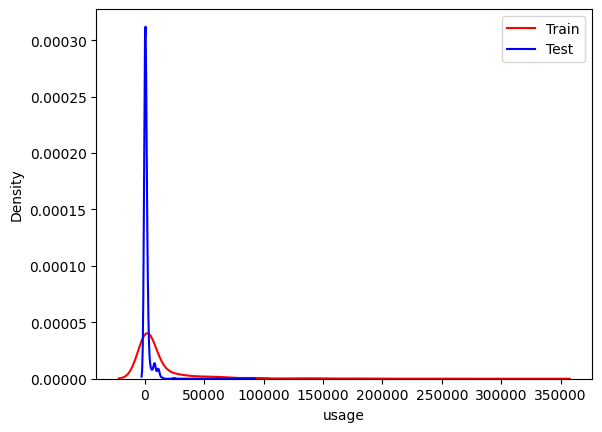

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(data["usage"], color="r", label="Train")
sns.kdeplot(impute_test["usage"], color="b", label="Test")
plt.legend()

In [194]:
data.loc[impute_test.index, "usage"] = impute_test["usage"]

In [195]:
data[data["usage"].isna()]

,city_name,routeno,routetp,startnodenm,endnodenm,startvehicletime,endvehicletime,intervaltime,intervalsattime,intervalsuntime,...,노선정류장수,노선거리(km),굴곡도,start,end,total_operating_time,interval_avg,num_bus,총인구수,노인(수)


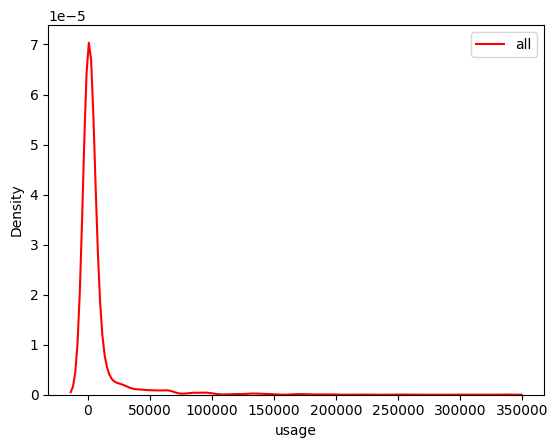

In [196]:
sns.kdeplot(data["usage"], color="r", label="all")
plt.legend()

In [197]:
data.to_csv("../data/usage.csv", index=False)